In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
config = {
    'domain': 'spouse',
    'supervision': 'majority',
#     'learn_deps': False,
#     'gen_model_search_space': 1,
#     'gen_init_params': {
#         'lf_propensity'         : True,
#         'class_prior'           : True,
#         'lf_class_propensity'   : True,
#         'seed'                  : None,
#     },
#     'gen_params_default': {
#         'step_size'     : 0.0001,
#         'decay'         : 0.90,
#         'reg_param'     : 0.50,
#         'epochs'        : 25,
#     },    
    'disc_model_class': 'logreg',    
    'disc_model_search_space': 10,
}

In [3]:
# Get DB connection string and add to globals
# NOTE: $SNORKELDB must be set before any snorkel imports
import os

default_db_name = 'babble_' + config['domain'] + ('_debug' if config.get('debug', False) else '')
DB_NAME = config.get('db_name', default_db_name)
if 'postgres' in config and config['postgres']:
    DB_TYPE = 'postgres'
else:
    DB_TYPE = 'sqlite'
    DB_NAME += '.db'
DB_ADDR = "localhost:{0}".format(config['db_port']) if 'db_port' in config else ""
os.environ['SNORKELDB'] = '{0}://{1}/{2}'.format(DB_TYPE, DB_ADDR, DB_NAME)
print("$SNORKELDB = {0}".format(os.environ['SNORKELDB']))

$SNORKELDB = sqlite:///babble_spouse.db


In [4]:
from snorkel import SnorkelSession
session = SnorkelSession()

# Resolve config conflicts (nb_config > local_config > global_config)
from snorkel.contrib.babble.pipelines import merge_configs, get_local_pipeline
config = merge_configs(config)

from snorkel.models import candidate_subclass
candidate_class = candidate_subclass(config['candidate_name'], config['candidate_entities'])

pipeline = get_local_pipeline(config['domain'])
pipe = pipeline(session, candidate_class, config)

Overwriting domain=None to domain=spouse
Overwriting print_freq=1 to print_freq=5
Overwriting LF_acc_prior_weight_default=1.0 to LF_acc_prior_weight_default=0.5
Overwriting decay=0.95 to decay=0.99
Overwriting init_class_prior=0 to init_class_prior=-1.15
Overwriting reg_param=0.1 to reg_param=0.5
Overwriting disc_model_class=lstm to disc_model_class=logreg
Overwriting supervision=generative to supervision=majority


In [5]:
# %time pipe.parse()

In [6]:
# %time pipe.extract()

In [7]:
# %time pipe.load_gold()

In [8]:
# %time pipe.featurize()

In [9]:
# %time pipe.collect()

In [10]:
# %time pipe.label()

In [11]:
%%time

import os
from tutorials.babble.spouse.spouse_qalf import QalfConverter

qc = QalfConverter(session, pipe.candidate_class)
fpath = (os.environ['SNORKELHOME'] + 
    '/tutorials/babble/spouse/data/qalf_matrix_hp.tsv')
L_train, L_dev, L_test = qc.convert(fpath)

pipe.L_train = L_train
pipe.L_dev = L_dev
pipe.L_test = L_test

CPU times: user 19.4 s, sys: 446 ms, total: 19.8 s
Wall time: 19.8 s


In [16]:
%time pipe.supervise()

Using L_train: <22195x24 sparse matrix of type '<type 'numpy.int64'>'
	with 9463 stored elements in Compressed Sparse Row format>
Using L_gold_train: <22195x1 sparse matrix of type '<type 'numpy.int64'>'
	with 22195 stored elements in Compressed Sparse Row format>
Positive Fraction: 7.0%

Using L_dev: <2796x24 sparse matrix of type '<type 'numpy.int64'>'
	with 1250 stored elements in Compressed Sparse Row format>
Using L_gold_dev: <2796x1 sparse matrix of type '<type 'numpy.int64'>'
	with 2796 stored elements in Compressed Sparse Row format>
Positive Fraction: 7.0%

Using L_test: <2697x24 sparse matrix of type '<type 'numpy.int64'>'
	with 1198 stored elements in Compressed Sparse Row format>
Using L_gold_test: <2697x1 sparse matrix of type '<type 'numpy.int64'>'
	with 2697 stored elements in Compressed Sparse Row format>
Positive Fraction: 8.3%

Saved 22195 marginals
CPU times: user 1.98 s, sys: 57.9 ms, total: 2.03 s
Wall time: 2.01 s


(22195,)


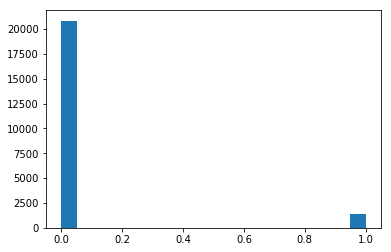

### [7.1] Begin training discriminative model
[1] Testing dim = 64, dropout = 2.50e-01, batch_size = 64, n_epochs = 50, lr = 1.00e-03, rebalance = 2.50e-01
[SparseLogisticRegression] Training model
[SparseLogisticRegression] n_train=5388  #epochs=50  batch size=64
[SparseLogisticRegression] Epoch 0 (0.55s)	Average loss=0.619325	Dev F1=16.37
[SparseLogisticRegression] Epoch 5 (3.53s)	Average loss=0.207024	Dev F1=43.90
[SparseLogisticRegression] Epoch 10 (6.44s)	Average loss=0.125583	Dev F1=45.19
[SparseLogisticRegression] Epoch 15 (9.33s)	Average loss=0.087903	Dev F1=45.11
[SparseLogisticRegression] Epoch 20 (12.23s)	Average loss=0.065986	Dev F1=45.26
[SparseLogisticRegression] Epoch 25 (15.15s)	Average loss=0.051135	Dev F1=44.60
[SparseLogisticRegression] Epoch 30 (18.11s)	Average loss=0.041605	Dev F1=45.61
[SparseLogisticRegression] Epoch 35 (21.08s)	Average loss=0.032945	Dev F1=45.71
[SparseLogisticRegression] Epoch 40 (24.08s)	Average loss=0.027062	Dev F1=45.82
[SparseLogisticRegres

In [17]:
%time pipe.classify()